In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install partitura
    !pip install python-hiddenmarkov
    !git clone https://github.com/MusicalInformatics/key_estimation
    import sys
    sys.path.insert(0, "./key_estimation/")

# Hidden Markov Models

## Quick Recap of Probability

* Probability: measure of the **likelihood** of an event

* $0\leq p(x) \leq 1$, 
    * $p(x) = 0$ indicates that the event is very unlikely to occur 
    * $p(x) = 1$ indicates that the event will most likely occur
    
* Random variables: $X$ can take values $x$

    
## Quick Recap: Graph Theory

* Graphs: A tuple $\mathcal{G}=(\mathbf{X}, \mathbf{E})$ consisting in a set of nodes $\mathbf{X} = \{X_1,\dots,X_N\}$ and a set of edges $\mathbf{E}$ connecting the nodes.

* Edges can be *directed* $(X_i \rightarrow X_j)$ or *undirected* $(X_i - X_j)$. If the nodes of a graph are directed, we call it a *directed Graph*, otherwise is an *undirected graph*
* Parent and Children nodes: In directed graphs, if $(X_i \rightarrow X_j)\in \mathbf{E}$ then $X_i$ is a parent of $X_j$ and $X_j$ is a child of $X_i$. 
    * $\mathbf{Pa}(X_i)$ is the set of parents of $X_i$
    * $\mathbf{Ch}(X_i)$ is the set of children of $X_i$
    
Let's consider this graph

<div>
<img src="img/graph_example.png" width="250"/>
</div>

* the parents of $X_3$ are $\mathbf{Pa}(X_3) = \{X_1, X_2\}$.
* Which are the parents of $X_4$?
* Which are the parents of $X_1$?


## Quick Recap: Probabilistic Graphical Models

* Probabilistic graphical models (PGMs) provide a way to visualize the structure of a probabilisitc model

* Easy and elegant way to represent conditional independence properties

* **Bayesian Networks**: Nodes in a graph represent *random variable* and edges specify conditional independence properties:

$$p(X_1, \dots, X_N) = \prod_{i=1}^{N} p(X_i \mid \mathbf{Pa}(X_i))$$


For the example above

$$p(X_1, X_2, X_3, X_4, X_5, X_6) = p(X_1) p(X_2) p(X_3\mid X_1, X_2) p(X_4 \mid X_3) p(X_5 \mid X_3) p(X_6 \mid X_3)$$

## Markov Models

* The simplest way of modeling a sequence of observations is to treat them as independent

<div>
<img src="img/independent_markov.png" width="250"/>
</div>

$$p(\mathbf{x}_1\dots, \mathbf{x}_N) = \prod_{n=1}^{N} p(\mathbf{x}_i)$$

but this is a poor assumption for inherently sequential data (like music!)

* Easy way to model sequential data: the conditional distribution of each variable is independent of all previous observations except for the most recent: *first-order Markov chain*

<div>
<img src="img/first_order_markov.png" width="250"/>
</div>

$$p(\mathbf{x}_1, \dots, \mathbf{x}_N) = p(\mathbf{x}_1)\prod_{n=2}^{N}p(\mathbf{x}_n \mid \mathbf{x}_{n-1})$$

## Hidden Markov Models

### Model Definition

A hidden Markov Model (HMM) is a *state space model* that is not limited by the Markov assumption to any order. To do this, for each observation $\mathbf{x}_n$, we have a corresponding *hidden* (latent) variable $\mathbf{z}_n$ that satisfies the conditional independence property that $\mathbf{z}_{n-1}$ and $\mathbf{z}_{n+1}$ are independent give $\mathbf{z}_n$.

<div>
<img src="img/hmm_example.png" width="250"/>
</div>

* Since an HMM is a Bayesian network, its joint probability distribution is given by
$$
p(\mathbf{x}_1, \dots, \mathbf{x}_{N-1}, \mathbf{z}_{1},\dots \mathbf{z}_{N-1})=p(\mathbf{z}_1) \left[ \prod_{n=2}^N p(\mathbf{z}_n \mid \mathbf{z}_{n-1})\right]\prod_{n=1}^N p(\mathbf{x}_n \mid \mathbf{z}_n)
$$

* In HMMs, the hidden variables $\mathbf{z}_n$ are discrete and are typically represented by multinomial variables. Therefore, it is convenient to use a 1-of-$K$ coding scheme. 

* The conditional distribution $p(\mathbf{z}_n \mid \mathbf{z}_{n -1})$ can be represented by a matrix $\mathbf{A}$, commonly referred to as *transition probabilities*.

$$A_{ij} = p(z_{ni} = 1 \mid  z_{n-1,j} = 1)$$

where $0\leq A_ij \leq 1$ and $\sum_j A_{ij} = 1$.

$$p(\mathbf{z}_n \mid \mathbf{z}_{n-1}) = \prod_{i=1}^K \prod_{j=1}^K A_{ij}^{z_{n-1,j} \cdot z_{n,i}}$$

* Since $\mathbf{z}_1$ has no parents, the marginal distribution $p(\mathbf{z}_1)$ is represented by a vector of probabilities $\mathbf{\pi}$ with elements $\pi_k = p(z_{1k} = 1)$

$$p(\mathbf{z}_1) = \prod_{k=1}^K \pi_k^{z_{1k}}$$

* The distribution of the observed variables (*emission probabilities*) is modeled by $p(\mathbf{x}_n \mid \mathbf{z}_n, \mathbf{\phi})$, where $\mathbf{\phi}$ is the set of parameters of this distribution.

$$ p(\mathbf{x}_n \mid \mathbf{z}_n) = \prod_{k=1}^K p(\mathbf{x}_n \mid  \mathbf{\phi}_k)^{z_{nk}} $$

* The set of parameters of the HMM is then $\mathbf{\theta} = \{\mathbf{\pi}, \mathbf{A}, \mathbf{\phi}\}$

### Example: Weather forcasting

As mentioned above, we can fully specify the HMM by defining 3 element
* an observation model that computes $p(\mathbf{x}_n \mid \mathbf{z}_n)$
* the transition probability matrix $\mathbf{A}$
* the initial probability vector $\mathbf{\pi}$

Let's start with a classical exaple for HMMs!

Imagine that you are working in a recording studio, and you spend most of the time in a **room without windows**. For the next few months you are going to be working with the same musicians, and you notice that some days they are wearing **jackets** and some other days they are bringing **umbrellas**! You start wondering if it is possible to know whether it is raning based on your observations of what the musicians are wearing.

Let's start by codifying our observed states and hidden states:

In [2]:
import numpy as np
from collections import defaultdict
from typing import Iterable, Tuple, Union
import matplotlib.pyplot as plt

%config InlineBackend.figure_format ='retina'

In [3]:
# These are the possible observed states
observed_states = (
    "normal",  # No jacket, no umbrella
    "jacket",
    "umbrella",
)

# Hidden (latent) states
hidden_states = (
    "Sunny",  # today is sunny
    "Raining",  # today is raining
)

After keeping track of the weather for a few weeks, we come to the following conditional probabilities:

(formally, in this case $\mathbf{x}_i$ can take $M=3$ different states and the probability $p(\mathbf{x}_n = m \mid \mathbf{z}_n = k) = c_{n,k}$ is constant).

In [4]:
observation_probabilities = np.array(
    [
        [0.5, 0.1],  # Probability of observing "normal" if "Sunny"/"Raining"
        [0.4, 0.3],  # Probability of observing "jacket" if "Sunny"/"Raining"
        [0.1, 0.6],  # Probability of observing "umbrella" if "Sunny"/"Raining"
    ]
)
transition_probabilities = np.array(
    [
        [
            0.7,
            0.4,
        ],  # P(today is "Sunny" | yesterday was "Sunny"), P(today is "Sunny" | yesterday was "Raining")
        [
            0.3,
            0.6,
        ],  # P(today is "Raining" | yesterday was "Sunny"), P(today is "Raining" | yesterday was "Raining")
    ]
)

init_distribution = np.array(
    [
        0.6,  # Probability that any given day is "Sunny"
        0.4,  # Probability that any given day is "Raining"
    ]
)

We are going to use the [`hiddenmarkov` package](https://github.com/neosatrapahereje/hiddenmarkov), which we prepared to help you implement HMMs. (You might need to install it in your environment via `pip install python-hiddenmarkov`)

In [5]:
from hiddenmarkov import CategoricalObservationModel, ConstantTransitionModel, HMM

observation_model = CategoricalObservationModel(
    observation_probabilities,
    observed_states,
    use_log_probabilities=False,
)

transition_model = ConstantTransitionModel(
    transition_probabilities,
    init_probabilities=init_distribution,
    use_log_probabilities=False,
)

# With the observation and transition models we can specify an HMM!
hmm = HMM(observation_model, transition_model, state_space=np.array(hidden_states))

In [6]:
obs = "normal"
# The observation model gives us the probability of an observation given the hidden states
print(observation_model(obs))

[0.5 0.1]


In [7]:
# The transition model tells us the proability of the current state given the previous state
transition_model(0, 0)

0.7

### Three Inference Problems with HMMs

1. Given $\mathbf{\theta}$ and a sequence of observations, find the most likely sequence of hidden varibles
    * Viterbi Algorithm
    
2. Given $\mathbf{\theta}$ and a sequence of observations, find the probability of the observed sequence
    * Forward algorithm (not covered here)
    
3. Given sequences of observations, learn the model parameters $\mathbf{\theta}$
    * Maximum likelihood Using Expectation-Maximization (also not covered here!)
    
For a more detailed (and formal) description, see the tutorial by [Pernkopf et al., 2013](https://www2.spsc.tugraz.at/www-archive/downloads/PGM.pdf).

### Viterbi Algorithm

* In many applications, the hidden variables have some meaningful interpretation:
    * In speech recognition: find the most probable sequence of phonemes
    * In bioinformatics: Aligning DNA/RNA sequences
    * In MIR: Music alignment, chord recognition, key identification...
    
* Formally, we would like to find

$$\hat{\mathbf{Z}} = \arg \max_\mathbf{Z} p(\mathbf{X}, \mathbf{Z})$$

where $\mathbf{X} = \{\mathbf{x}_1, \dots, \mathbf{x}_N\}$ and $\mathbf{Z} = \{\mathbf{z}_1,\dots, \mathbf{z}_N \}$

* Direct optimization of the joint distribution might not be feasible!

* Viterbi Algorithm: Use dynamic programming (like in DTW!)

* We define
$$\omega(\mathbf{z}_n) = \max_{\mathbf{z}_1, \dots, \mathbf{z}_{n - 1}}\log p(\mathbf{x}_1,\dots, \mathbf{x}_{n-1}, \mathbf{z}_1,\dots, \mathbf{z}_{n-1})$$

(compare to the Dynamic Time Warping distance!)

#### Algorithm 

**Inputs**  
    
* Sequence of observations $\mathbf{X}=\{\mathbf{x}_1, \dots, \mathbf{x}_N\}$
* Input probabilities $\mathbf{\pi}$
* Transition Matrix $\mathbf{A}$
* Observation model (to compute $p(\mathbf{x}_{n} \mid \mathbf{z}_n)$)

**Initialization**

We want to compute

$$\omega(\mathbf{z}_1) =  \log p(\mathbf{x}_1 \mid \mathbf{z}_1) + \log p(\mathbf{z}_1)$$

* For $k \in [1, K]$
    $$ \omega_{1k} = p(\mathbf{x}_1 \mid  \mathbf{\phi}_k) + \log \pi_k $$

**Viterbi interation**

We want to compute

$$\omega(\mathbf{z}_n) = \log p(\mathbf{x}_{n} \mid \mathbf{z}_{n}) + \max_{\mathbf{z}_n} \left\{\log p(\mathbf{z}_{n} \mid \mathbf{z}_{n-1}) + \omega(\mathbf{z}_{n - 1})  \right\}$$

* For $n\in[2, N]$
    * For $k \in [1, K]$
        $$\omega_{nk} = p(\mathbf{x}_n \mid  \mathbf{\phi}_k) + \max_i\{ A_{ik} + \omega_{n-1, i} \}$$
        
        
Let's put this together into a single function!

In [8]:
def viterbi_algorithm(
    hmm: HMM,
    observations: Iterable,
    log_probabilities: bool = True,
    return_omega: bool = False,
) -> Union[Tuple[np.ndarray, float], Tuple[np.ndarray, float, np.ndarray]]:
    """
    Find the most probable sequence of latent variables given
    a sequence of observations

    Parameters
    ----------
    observations: iterable
       An iterable containing observations. The type of each
       element depends on input types accepted by the
       `hmm.observation_model`
    log_probabilities: Bool (optional)
       If True, uses log probabilities to compute the Viterbi
       recursion (better for numerical stability). Default is True.
    return_omega: bool
       If True, return omega

    Returns
    -------
    path: np.ndarray
        The most probable sequence of latent variables
    likelihood: float
        The likelihood (either the probability or the
        log proability if `log_probabilities` is True)
        of the best sequence.
    omega : np.ndarray

    Note
    ----
    This is a naïve implementation, mostly for educational purposes!
    """
    # Set whether to use log probabilities in transition and
    # observation models
    hmm.transition_model.use_log_probabilities = log_probabilities
    hmm.observation_model.use_log_probabilities = log_probabilities
    # Initialize matrix for holding the best sub-sequence
    # (log-)likelihood
    omega = np.zeros((len(observations), hmm.n_states))
    # Initialize dictionary for tracking the best paths
    path = defaultdict(lambda: list())

    # Initiate for i == 0
    obs_prob = hmm.observation_model(observations[0])

    if log_probabilities:
        omega[0, :] = obs_prob + hmm.transition_model.init_probabilities
    else:
        omega[0, :] = obs_prob * hmm.transition_model.init_probabilities

    # Viterbi recursion
    for i, obs in enumerate(observations[1:], 1):
        obs_prob = hmm.observation_model(obs)
        for j in range(hmm.n_states):
            if log_probabilities:
                prob, state = max(
                    [
                        (omega[i - 1, k] + hmm.transition_model(k, j), k)
                        for k in range(hmm.n_states)
                    ],
                    key=lambda x: x[0],
                )
                omega[i, j] = obs_prob[j] + prob

            else:
                prob, state = max(
                    [
                        (omega[i - 1, k] * hmm.transition_model(k, j), k)
                        for k in range(hmm.n_states)
                    ],
                    key=lambda x: x[0],
                )
                omega[i, j] = obs_prob[j] * prob
            # keep track of the best state
            path[j].append(state)

    # Get best path (backtracking!)
    # Get index of the best state
    best_sequence_idx = omega[-1, :].argmax()
    # likelihood of the path
    path_likelihood = omega[-1, best_sequence_idx]
    # follow the best path backwards
    seq = [best_sequence_idx]
    for s in range(len(path[best_sequence_idx])):
        best_sequence_idx = path[best_sequence_idx][-(s + 1)]
        seq.append(best_sequence_idx)
    # invert the path
    best_sequence = np.array(seq[::-1], dtype=int)

    if hmm.state_space is not None:
        best_sequence = hmm.state_space[best_sequence]

    if return_omega:
        return best_sequence, path_likelihood, omega

    return best_sequence, path_likelihood

### Weather Report!

Let's go back to our example!

Best sequence:
['Raining' 'Raining' 'Raining' 'Sunny' 'Sunny' 'Sunny' 'Sunny']


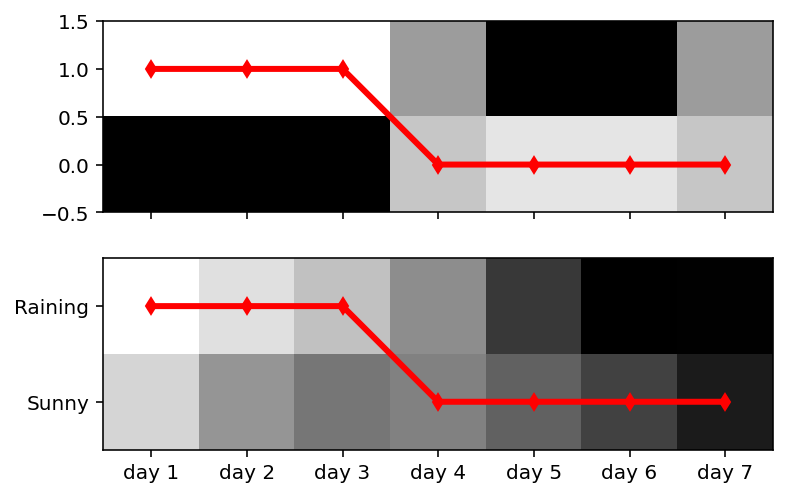

In [9]:
observations = [
    "umbrella",
    "umbrella",
    "umbrella",
    "jacket",
    "normal",
    "normal",
    "jacket",
]

best_sequence, likelihood, omega = viterbi_algorithm(
    hmm, observations, log_probabilities=True, return_omega=True,
)

best_seq_indices = np.array([hidden_states.index(bs) for bs in best_sequence])

observation_probs = np.array([hmm.observation_model(obs) for obs in observations])

print("Best sequence:")
print(best_sequence)

fig, axes = plt.subplots(2, sharex=True)
axes[0].plot(
    np.arange(len(observations)), best_seq_indices, marker="d", color="red", linewidth=3
)
axes[1].plot(
    np.arange(len(observations)), best_seq_indices, marker="d", color="red", linewidth=3
)
axes[0].imshow(observation_probs.T, aspect="equal", origin="lower", cmap="gray")
axes[1].set_yticks(range(2))
axes[1].set_yticklabels(["Sunny", "Raining"])
axes[1].imshow(omega.T, aspect="equal", origin="lower", cmap="gray")
axes[1].set_xticks(range(len(observations)))
axes[1].set_xticklabels([f"day {i + 1}" for i in range(len(observations))])
axes[1].set_yticks(range(2))
axes[1].set_yticklabels(["Sunny", "Raining"])
plt.show()